# Acces to GDrive
These cells give access to your Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import auth
auth.authenticate_user()

#Importations

In [3]:
import gspread
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import *


import seaborn as sns
import matplotlib.pyplot as plt  

#Data extraction
These cells load the time series (from the json files) and labels (from data.csv).

In [4]:
gc = gspread.authorize(GoogleCredentials.get_application_default())
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1m2l52fMnXSO_SIp_LRnX-NTjt50RJhwYdJ4cCKX1xa8/edit#gid=0')
data = wb.worksheet('data').get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
df = df.iloc[1:]

In [5]:
start = 0
end = 385
sub_df = df[start:end]
sub_df.head()

,Name,Gender (W/M),"Fail, Zone or Top (0/1/2)",Competition,Climber,Country,Boulder Label
1,c1.mp4,M,0,WC (2021),Yannick Flohé,GER,1
2,c2.mp4,M,0,WC (2021),Jan Hojer,GER,2
3,c3.mp4,M,0,WC (2021),Yannick Flohé,GER,1
4,c4.mp4,M,1,WC (2021),Jan Hojer,GER,2
5,c5.mp4,M,1,WC (2021),Jan Hojer,GER,2


In [6]:
path = '/content/drive/MyDrive/Boulder Project/'
names = sub_df["Name"].values

In [7]:
df = []
y_climber = []
y_success = []
frames = 1
n = 0
for idx in range(len(names)):
  for ending in [".MOV", ".mp4"]:
    names[idx] = names[idx].replace(ending, "")
  path_landmarks = path + "json/" + names[idx] + "_landmarks.json"
  data = pd.read_json(path_landmarks)

  if len(data) >=frames:
    df.append(data[:frames])

    y_climber.append(sub_df['Climber'][idx+1])
    y_success.append(sub_df['Fail, Zone or Top (0/1/2)'][idx+1])

    n += 1

df = pd.concat(df)
keys = df.keys()[:15]
for key in keys:
  x = key + "_x"
  y = key + "_y"
  df[x] = np.vstack(df[key].values)[:,0]
  df[y] = np.vstack(df[key].values)[:,1]

df = df.drop(columns = keys)

#Random Forest 10-fold CV  (using the start coordinates as features)

In [ ]:
y_climber = pd.Series(data = y_climber, index = np.arange(0,385))
y_success = pd.Series(data = y_success, index = np.arange(0,385))

In [ ]:
features = df

In [ ]:
k = 10

N = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
D = [10, 25, 50,100,150]

acc_train = np.zeros((len(N), len(D)))
acc_test = np.zeros((len(N), len(D)))

kf = KFold(n_splits=k, shuffle = True, random_state = 1)

for i, n in enumerate(N):
  for j, d in enumerate(D): 
    tmp_train = []
    tmp_test = []
    for train, test in kf.split(y_climber):
      X_train = np.array(features)[train]
      X_test = np.array(features)[test]
      Y_train = y_climber[train].values
      Y_test = y_climber[test].values
      clf_climber=RandomForestClassifier(n_estimators=int(n), max_depth = int(d), random_state = 1)
      clf_climber.fit(X_train,Y_train)
      y_pred_test=clf_climber.predict(X_test)
      y_pred_train=clf_climber.predict(X_train)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))

    acc_train[i,j] = np.mean(tmp_train)
    acc_test[i,j] = np.mean(tmp_test)

In [ ]:
best_test = np.unravel_index(np.argmax(acc_test, axis=None), acc_test.shape) 
print(best_test)
print(acc_test[best_test])

(3, 1)
0.49865047233468285


In [ ]:
acc_test

array([[0.45222672, 0.47537112, 0.47537112, 0.47537112, 0.47537112],
       [0.45991903, 0.48825911, 0.48825911, 0.48825911, 0.48825911],
       [0.45991903, 0.49338731, 0.49338731, 0.49338731, 0.49338731],
       [0.47031039, 0.49865047, 0.49865047, 0.49865047, 0.49865047],
       [0.4754386 , 0.49338731, 0.49338731, 0.49338731, 0.49338731],
       [0.4780027 , 0.49075574, 0.49075574, 0.49075574, 0.49075574],
       [0.47537112, 0.49601889, 0.49601889, 0.49601889, 0.49601889],
       [0.47280702, 0.49358974, 0.49358974, 0.49358974, 0.49358974],
       [0.4754386 , 0.48832659, 0.48832659, 0.48832659, 0.48832659],
       [0.47537112, 0.49089069, 0.49089069, 0.49089069, 0.49089069]])

In [ ]:
acc_train

array([[0.99624694, 1.        , 1.        , 1.        , 1.        ],
       [0.99624611, 1.        , 1.        , 1.        , 1.        ],
       [0.99855658, 1.        , 1.        , 1.        , 1.        ],
       [0.99797854, 1.        , 1.        , 1.        , 1.        ],
       [0.99739968, 1.        , 1.        , 1.        , 1.        ],
       [0.99855491, 1.        , 1.        , 1.        , 1.        ],
       [0.99826673, 1.        , 1.        , 1.        , 1.        ],
       [0.99826673, 1.        , 1.        , 1.        , 1.        ],
       [0.99913378, 1.        , 1.        , 1.        , 1.        ],
       [0.9988456 , 1.        , 1.        , 1.        , 1.        ]])

In [ ]:
k = 10

N = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
D = [10, 25, 50,100,150]

acc_train = np.zeros((len(N), len(D)))
acc_test = np.zeros((len(N), len(D)))

kf = KFold(n_splits=k, shuffle = True, random_state = 1)

for i, n in enumerate(N):
  for j, d in enumerate(D): 
    tmp_train = []
    tmp_test = []
    for train, test in kf.split(y_success):
      X_train = np.array(features)[train]
      X_test = np.array(features)[test]
      Y_train = y_success[train].values
      Y_test = y_success[test].values
      clf_climber=RandomForestClassifier(n_estimators=int(n), max_depth = int(d), random_state = 1)
      clf_climber.fit(X_train,Y_train)
      y_pred_test=clf_climber.predict(X_test)
      y_pred_train=clf_climber.predict(X_train)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))

    acc_train[i,j] = np.mean(tmp_train)
    acc_test[i,j] = np.mean(tmp_test)

In [ ]:
best_test = np.unravel_index(np.argmax(acc_test, axis=None), acc_test.shape) 
print(best_test)
print(acc_test[best_test])

(1, 0)
0.5665317139001351


In [ ]:
print(acc_train)
print(acc_test)

[[0.98932302 1.         1.         1.         1.        ]
 [0.99220653 1.         1.         1.         1.        ]
 [0.99422882 1.         1.         1.         1.        ]
 [0.99509503 1.         1.         1.         1.        ]
 [0.9939398  1.         1.         1.         1.        ]
 [0.99451783 1.         1.         1.         1.        ]
 [0.99422965 1.         1.         1.         1.        ]
 [0.99422798 1.         1.         1.         1.        ]
 [0.99567057 1.         1.         1.         1.        ]
 [0.9956714  1.         1.         1.         1.        ]]
[[0.54331984 0.54838057 0.54838057 0.54838057 0.54838057]
 [0.56653171 0.53805668 0.53805668 0.53805668 0.53805668]
 [0.56390013 0.55364372 0.55364372 0.55364372 0.55364372]
 [0.55607287 0.55357625 0.55357625 0.55357625 0.55357625]
 [0.56140351 0.54581646 0.54581646 0.54581646 0.54581646]
 [0.55877193 0.55101215 0.55101215 0.55101215 0.55101215]
 [0.55350877 0.54844804 0.54844804 0.54844804 0.54844804]
 [0.56140351 

# Confusion matrix (with Random Forest using the optimized Parameters)

In [8]:
features = df

In [9]:
y_c = pd.Series(data = y_climber, index = np.arange(0,385))
y_s = pd.Series(data = y_success, index = np.arange(0,385))

In [10]:
n_c = 200
d_c = 25
n_s = 150
d_s = 10

In [12]:
k = 10
unique_c = y_c.unique()
kf = KFold(n_splits=k, shuffle = True, random_state = 1)
M = np.zeros((23,23))
tmp_train = []
tmp_test = []
tmp_ajusted_train = []
tmp_ajusted_test = []

for train, test in kf.split(y_c):
      X_train = np.array(features)[train]
      X_test = np.array(features)[test]
      Y_train = y_c[train].values
      Y_test = y_c[test].values
      clf=RandomForestClassifier(n_estimators=n_c, max_depth = d_c, random_state = 1)
      clf.fit(X_train,Y_train)
      y_pred_test=clf.predict(X_test)
      y_pred_train=clf.predict(X_train)
      M = M + metrics.confusion_matrix(Y_test, y_pred_test, labels = unique_c)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))
      tmp_ajusted_train.append(metrics.balanced_accuracy_score(Y_train, y_pred_train))
      tmp_ajusted_test.append(metrics.balanced_accuracy_score(Y_test, y_pred_test))

M = M/np.sum(M)
print('train accuracy = ' + str(np.mean(tmp_train)))
print('test accuracy = ' +  str(np.mean(tmp_test)))
print('train ajusted accuracy = ' + str(np.mean(tmp_ajusted_train)))
print('test ajusted accuracy = ' +  str(np.mean(tmp_ajusted_test)))
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_clas

train accuracy = 1.0
test accuracy = 0.49865047233468285
train ajusted accuracy = 1.0
test ajusted accuracy = 0.4262454152989867


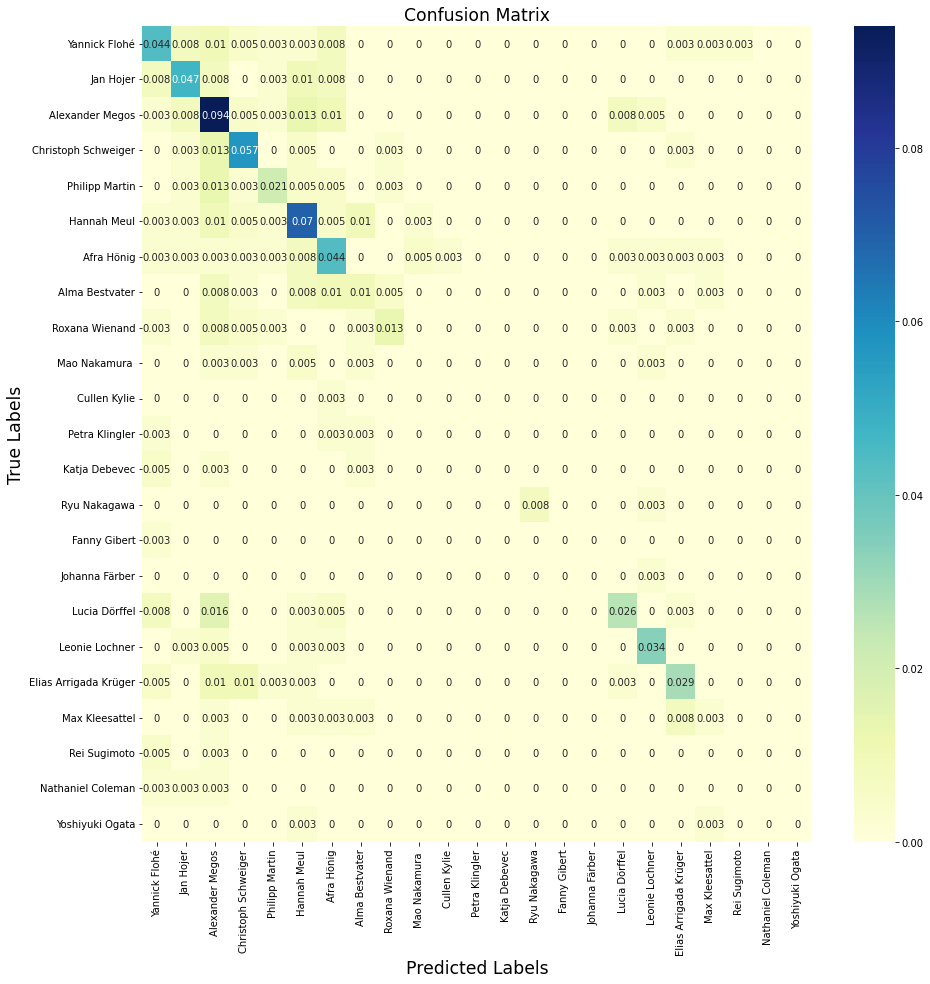

In [13]:
images_dir = '/content/drive/MyDrive/Boulder Project/figures/'

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(np.round(M,3), annot=True, fmt='g', xticklabels = unique_c, yticklabels = unique_c, ax = ax, cmap="YlGnBu")
ax.set_xlabel('Predicted Labels', fontsize = 'xx-large')
ax.set_ylabel('True Labels', fontsize = 'xx-large')
ax.set_title('Confusion Matrix', fontsize = 'xx-large')
fig.savefig(f"{images_dir}Confusion_Matrix_climber_1F.png")
fig.show()

In [15]:
k = 10
unique_s = y_s.unique()
kf = KFold(n_splits=k, shuffle = True, random_state = 1)
M = np.zeros((3,3))
tmp_train = []
tmp_test = []
tmp_ajusted_train = []
tmp_ajusted_test = []

for train, test in kf.split(y_s):
      X_train = np.array(features)[train]
      X_test = np.array(features)[test]
      Y_train = y_s[train].values
      Y_test = y_s[test].values
      clf=RandomForestClassifier(n_estimators=n_s, max_depth = d_s, random_state = 1)
      clf.fit(X_train,Y_train)
      y_pred_test=clf.predict(X_test)
      y_pred_train=clf.predict(X_train)
      M = M + metrics.confusion_matrix(Y_test, y_pred_test, labels = unique_s)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))
      tmp_ajusted_train.append(metrics.balanced_accuracy_score(Y_train, y_pred_train))
      tmp_ajusted_test.append(metrics.balanced_accuracy_score(Y_test, y_pred_test))

M = M/np.sum(M)
print('train accuracy = ' + str(np.mean(tmp_train)))
print('test accuracy = ' +  str(np.mean(tmp_test)))
print('train ajusted accuracy = ' + str(np.mean(tmp_ajusted_train)))
print('test ajusted accuracy = ' +  str(np.mean(tmp_ajusted_test)))
      

train accuracy = 0.994228815112192
test accuracy = 0.5639001349527666
train ajusted accuracy = 0.9909310324188242
test ajusted accuracy = 0.39112579769317574


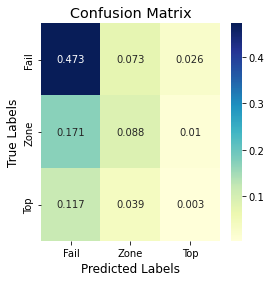

In [17]:
images_dir = '/content/drive/MyDrive/Boulder Project/figures/'
labels = ['Fail', 'Zone', 'Top']

fig, ax = plt.subplots(figsize=(4,4))         # Sample figsize in inches
sns.heatmap(np.round(M,3), annot=True, fmt='g', xticklabels = labels, yticklabels = labels, ax = ax, cmap="YlGnBu")
ax.set_xlabel('Predicted Labels', fontsize = 'large')
ax.set_ylabel('True Labels', fontsize = 'large')
ax.set_title('Confusion Matrix', fontsize = 'x-large')
fig.savefig(f"{images_dir}Confusion_Matrix_success_1F.png")
fig.show()